In [5]:
# !pip install qutip
from qutip import *
from math import *
import itertools
from itertools import product
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool

font = {'size'   : 17}

matplotlib.rc('font', **font)
# matplotlib.rcParams['text.usetex'] = True
# plt.rcParams["figure.figsize"]= 6, 4
plt.rcParams['figure.dpi'] = 90
matplotlib.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True
 

# Exact diagonalization of fixed-point Hamiltonian

In [6]:
def imp_energy(Ek_0, V, J, K, U, ed):
    dim = len(Ek_0)
    ed = -U/2
    imp_ed_up = [create(2)*destroy(2), identity(2)]
    imp_ed_dn = [identity(2), create(2)*destroy(2)]
    imp_U = [create(2)*destroy(2), create(2)*destroy(2)]
    bath = [identity(2)]*2*dim
    return ed*tensor(imp_ed_up+bath) + ed*tensor(imp_ed_dn+bath) + U*tensor(imp_U+bath)


def kin_en(Ek_0, V, J, K, U, ed):
    H = 0
    dim = len(Ek_0)
    for i in range(dim):
        for sigma in ["u", "d"]:
            # print (i, sigma)
            imp = [identity(2)]*2
            bef = [identity(2)]*2*i
            tau = create(2)*destroy(2) - 1/2
            curr = [Ek_0[i]*tau, identity(2)] if sigma == "u" else [identity(2), Ek_0[i]*tau]
            aft = [identity(2)]*2*(dim - i - 1)
            mats = imp+bef+curr+aft
            H += tensor(mats)
    return H


def hyb(Ek_0, V, J, K, U, ed):
    H = 0
    dim = len(Ek_0)
    for i in range(dim):
        for sigma in ["u", "d"]:
            # print (i, sigma)
            tau = create(2)*destroy(2) - 1/2
            if sigma == "u":
                mats1 = [destroy(2), identity(2)] + [identity(2)]*2*i + [create(2), identity(2)] + [identity(2)]*2*(dim - i - 1)
                mats2 = [create(2), identity(2)] + [identity(2)]*2*i + [destroy(2), identity(2)] + [identity(2)]*2*(dim - i - 1)
            else:
                mats1 = [identity(2), destroy(2)] + [identity(2)]*2*i + [identity(2), create(2)] + [identity(2)]*2*(dim - i - 1)
                mats2 = [identity(2), create(2)] + [identity(2)]*2*i + [identity(2), destroy(2)] + [identity(2)]*2*(dim - i - 1)
            H += -tensor(mats1) + tensor(mats2)
    return V * H
    
    
def spin(Ek_0, V, J, K, U, ed):
    H = 0
    dim = len(Ek_0)
    idt = identity(2)
    Sdz = 0.5 * (tensor(create(2)*destroy(2), identity(2)) - tensor(identity(2), create(2)*destroy(2)))
    Sdplus = tensor(create(2), destroy(2))
    Sdmin = -tensor(destroy(2), create(2))
    Ksz = Ksplus = Ksmin = 0
    for i,j in product(range(dim), range(dim)):
        # print (i,j)
        if i < j:
            Ksz += 0.5 * tensor([idt]*2*i + [create(2), idt] + [idt]*2*(j - i - 1) + [destroy(2), idt] + [idt]*2*(dim - j - 1))
            Ksz -= 0.5 * tensor([idt]*2*i + [idt, create(2)] + [idt]*2*(j - i - 1) + [idt, destroy(2)] + [idt]*2*(dim - j - 1))
            Ksplus += tensor([idt]*2*i + [create(2), idt] + [idt]*2*(j - i - 1) + [idt, destroy(2)] + [idt]*2*(dim - j - 1))
            Ksmin += tensor([idt]*2*i + [idt, destroy(2)] + [idt]*2*(j - i - 1) + [create(2), idt] + [idt]*2*(dim - j - 1))
        elif i > j:
            Ksz -= 0.5 * tensor([idt]*2*j + [destroy(2), idt] + [idt]*2*(i - j - 1) + [create(2), idt] + [idt]*2*(dim - i - 1))
            Ksz += 0.5 * tensor([idt]*2*j + [idt, destroy(2)] + [idt]*2*(i - j - 1) + [idt, create(2)] + [idt]*2*(dim - i - 1))
            Ksplus -= tensor([idt]*2*j + [idt, destroy(2)] + [idt]*2*(i - j - 1) + [create(2), idt] + [idt]*2*(dim - i - 1))
            Ksmin -= tensor([idt]*2*j + [create(2), idt] + [idt]*2*(i - j - 1) + [idt, destroy(2)] + [idt]*2*(dim - i - 1))
        else:
            Ksz += 0.5 * tensor([idt]*2*i + [create(2)*destroy(2), idt] + [idt]*2*(dim - i - 1))
            Ksz -= 0.5 * tensor([idt]*2*i + [idt, create(2)*destroy(2)] + [idt]*2*(dim - i - 1))
            Ksplus += tensor([idt]*2*i + [create(2), destroy(2)] + [idt]*2*(dim - i - 1))
            Ksmin -= tensor([idt]*2*i + [destroy(2), create(2)] + [idt]*2*(dim - i - 1))

    return J * (tensor(Sdz, Ksz) + 0.5*tensor(Sdplus, Ksmin) + 0.5*tensor(Sdmin, Ksplus))


def charge(Ek_0, V, J, K, U, ed):
    H = 0
    dim = len(Ek_0)
    idt = identity(2)
    Cdz = 0.5 * (tensor(create(2)*destroy(2), identity(2)) + tensor(identity(2), create(2)*destroy(2)) - 1)
    Cdplus = tensor(create(2), create(2))
    Cdmin = -tensor(destroy(2), destroy(2))
    Kcz = -dim/2
    Kcplus = Kcmin = 0
    for i,j in product(range(dim), range(dim)):
        # print (i,j)
        if i < j:
            Kcz += 0.5 * tensor([idt]*2*i + [create(2), idt] + [idt]*2*(j - i - 1) + [destroy(2), idt] + [idt]*2*(dim - j - 1))
            Kcz += 0.5 * tensor([idt]*2*i + [idt, create(2)] + [idt]*2*(j - i - 1) + [idt, destroy(2)] + [idt]*2*(dim - j - 1))
            Kcplus += tensor([idt]*2*i + [create(2), idt] + [idt]*2*(j - i - 1) + [idt, create(2)] + [idt]*2*(dim - j - 1))
            Kcmin += tensor([idt]*2*i + [idt, destroy(2)] + [idt]*2*(j - i - 1) + [destroy(2), idt] + [idt]*2*(dim - j - 1))
        elif i > j:
            Kcz -= 0.5 * tensor([idt]*2*j + [destroy(2), idt] + [idt]*2*(i - j - 1) + [create(2), idt] + [idt]*2*(dim - i - 1))
            Kcz -= 0.5 * tensor([idt]*2*j + [idt, destroy(2)] + [idt]*2*(i - j - 1) + [idt, create(2)] + [idt]*2*(dim - i - 1))
            Kcplus -= tensor([idt]*2*j + [idt, create(2)] + [idt]*2*(i - j - 1) + [create(2), idt] + [idt]*2*(dim - i - 1))
            Kcmin -= tensor([idt]*2*j + [destroy(2), idt] + [idt]*2*(i - j - 1) + [idt, destroy(2)] + [idt]*2*(dim - i - 1))
        else:
            Kcz += 0.5 * tensor([idt]*2*i + [create(2)*destroy(2), idt] + [idt]*2*(dim - i - 1))
            Kcz += 0.5 * tensor([idt]*2*i + [idt, create(2)*destroy(2)] + [idt]*2*(dim - i - 1))
            Kcplus += tensor([idt]*2*i + [create(2), create(2)] + [idt]*2*(dim - i - 1))
            Kcmin -= tensor([idt]*2*i + [destroy(2), destroy(2)] + [idt]*2*(dim - i - 1))

    return K * (tensor(Cdz, Kcz) + 0.5*tensor(Cdplus, Kcmin) + 0.5*tensor(Cdmin, Kcplus))

# Spectral Function

## $T=0$

In [7]:
def rho_at_w(args):
    [Em, Emp],[Xm,Xmp], w = args
    cdag_up = tensor([create(2), identity(2)] + [identity(2)]*2*len(Ek_0))
    Vmmp_1 = Xm.dag()*cdag_up*Xmp
    Vmmp_2 = Xmp.dag()*cdag_up*Xm
    Vmmp_1_sq = np.real((Vmmp_1*Vmmp_1.dag())[0][0][0])
    Vmmp_2_sq = np.real((Vmmp_2*Vmmp_2.dag())[0][0][0])
    x1 = w + Em
    x2 = w - Em
    eta = abs(max(Ek_0))      # width of broadening function
    return (Vmmp_1_sq * exp(-(x1/eta)**2)/(eta*sqrt(pi)) + Vmmp_2_sq * exp(-(x2/eta)**2)/(eta*sqrt(pi))) / Z

def plot_A(U, V, J, U0, J0, show=True, title=True):
    # U = 0.5, 0.3, 0.2, 0.1, 0
    # J = 0.3, 0.25, 0.2, 0.15, 0.05
    # V = 0.019909015762077577
    K = J
    ed = -U/2
    H = kin_en(Ek_0, V, J, K, U, ed)
    H += imp_energy(Ek_0, V, J, K, U, ed)
    H += hyb(Ek_0, V, J, K, U, ed)
    H += spin(Ek_0, V, J, K, U, ed)
    H += charge(Ek_0, V, J, K, U, ed)
    H = 0.5 * (H + H.dag())
    E, X = H.eigenstates()
    E = np.array(E)
    zeroE = E[np.where(np.abs(np.round(E,9)) == 0)]
    zeroX = X[np.where(np.abs(np.round(E,9)) == 0)]
    global Z
    Z = len(E)
    rho = []
    for w in tqdm(w_range):
        rho_w = sum(Pool(processes=20).map(rho_at_w, zip(product(E, zeroE), product(X, zeroX), np.ones(len(E)*len(zeroE))*w)))
        rho.append(rho_w)

    plt.plot(w_range, rho)
    plt.xlabel(r"$\omega$")
    plt.ylabel(r"$\mathcal{A(\omega)}$")
    if title == True:
        plt.title(r"$U={}, J={}$".format(U0, J0))
    if show == True:
        plt.show()
    return rho

100%|██████████| 201/201 [04:38<00:00,  1.39s/it]


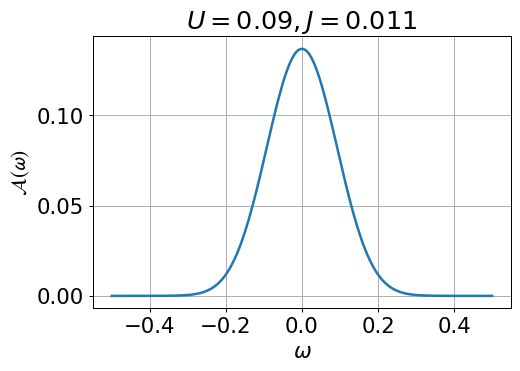

In [9]:
global Ek_0, w_range
Ek_0 = np.array([-0.1, 0, 0.1])
w_range = np.arange(-0.5, 0.505, 0.005)

U = 0.0886301794495707
V = 0.006315372549557469
J = 0.03175939200139961

U0 = 0.09
J0 = 0.011
rho_1 = plot_A(U,V,J,U0,J0)


100%|██████████| 201/201 [04:01<00:00,  1.20s/it]


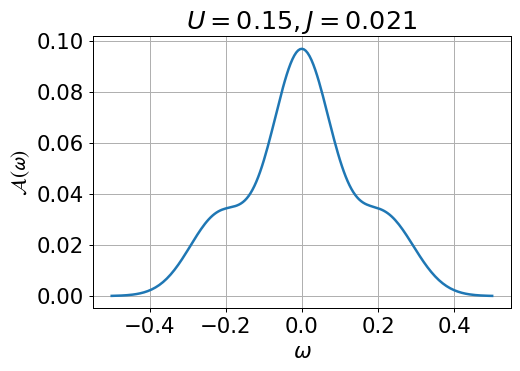

In [6]:
global Ek_0, w_range
Ek_0 = np.array([-0.1, 0, 0.1])
w_range = np.arange(-0.5, 0.505, 0.005)
U = 0.14544161847480389
V = 0.01983202407440915
J = 0.11130436896180042
U0 = 0.15
J0 = 0.021

rho_3 = plot_A(U,V,J,U0,J0)

100%|██████████| 301/301 [07:09<00:00,  1.43s/it]


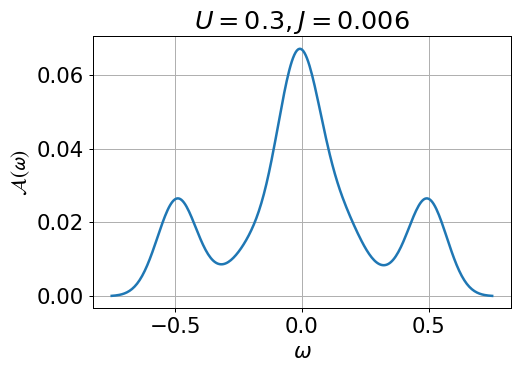

In [5]:
global Ek_0, w_range
Ek_0 = np.array([-0.1, 0, 0.1])
w_range = np.arange(-0.75, 0.755, 0.005)
U = 0.29902982486011265
V = 0.01339673557864031
J = 0.24051449872105585
U0 = 0.3
J0 = 0.006

rho_2 = plot_A(U,V,J,U0,J0)

100%|██████████| 200/200 [08:06<00:00,  2.43s/it]


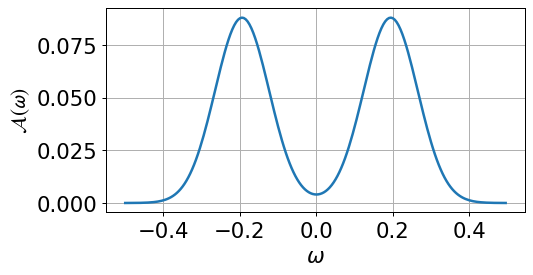

100%|██████████| 200/200 [06:12<00:00,  1.86s/it]


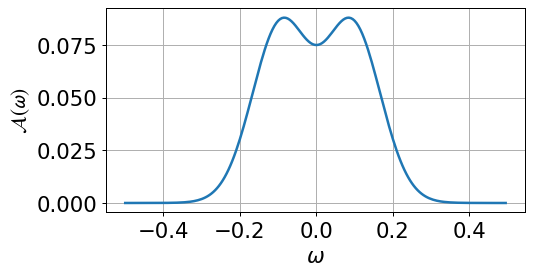

100%|██████████| 200/200 [06:29<00:00,  1.95s/it]


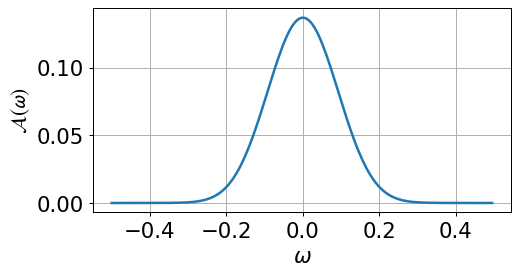

In [8]:
global Ek_0, w_range
Ek_0 = np.array([-0.1, 0, 0.1])
w_range = np.arange(-0.5, 0.5, 0.005)
V = 0.006315372549557469
U0 = 0.3
J0 = 0.006
plt.rcParams["figure.figsize"]= 6, 3
for U,J in zip([0.3886301794495707, 0.1886301794495707,0.0886301794495707], [0.001175939200139961, 0.021175939200139961, 0.03175939200139961]):
    rho_2 = plot_A(U,V,J,U0,J0, title=False)

100%|██████████| 151/151 [00:42<00:00,  3.54it/s]


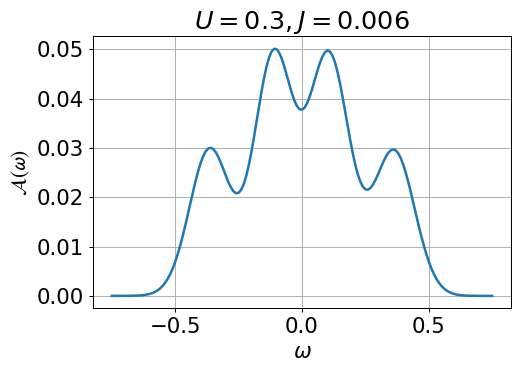

In [16]:
global Ek_0, w_range
Ek_0 = np.array([-0.1, 0, 0.1])
w_range = np.arange(-0.75, 0.755, 0.01)
U = 0.40902982486011265
V = 0.01339673557864031
J = 0.12051449872105585
U0 = 0.3
J0 = 0.006

rho_2 = plot_A(U,V,J,U0,J0)

In [7]:
def rho_at_w(args):
    [Em, Emp],[Xm,Xmp] = args
    cdag_up = tensor([create(2), identity(2)] + [identity(2)]*2*len(Ek_0))
    Vmmp = Xm.dag()*cdag_up*Xmp
    Vmmp_sq = np.real((Vmmp*Vmmp.dag())[0][0][0])
    x = w - Emp + Em
    eta = abs(max(Ek_0))      # width of broadening function
    return Vmmp_sq * exp(-(x/eta)**2)/(eta*sqrt(pi)) * (exp(-beta*Em) + exp(-beta*Emp)) / Z

Ek_0 = np.array([-0.2, -0.1, 0.1, 0.2])
# print (Ek_0)
U = 0.1
V = 0.019909015762077577
J = 0.015838964056748835
K = J
plt.rcParams["figure.figsize"]= 12, 4
H = kin_en(Ek_0, V, J, K, U)
# H += imp_energy(Ek_0, V, J, K, U)
H += hyb(Ek_0, V, J, K, U)
H += spin(Ek_0, V, J, K, U)
H += charge(Ek_0, V, J, K, U)
H = 0.5 * (H + H.dag())
E, X = H.eigenstates()
# E = np.array(E)
T = 0.1
kb = 1
beta = 1/(kb*T)
Z = sum(np.exp(-beta*E))
w_range = np.arange(-1, 1, 0.05)
rho = []
for w in tqdm(w_range):
    rho_w = sum(Pool(processes=10).map(rho_at_w, zip(product(E, E), product(X, X))))
    rho.append(rho_w)
    # for [Em, Emp],[Xm,Xmp] in zip(product(E, E), product(X, X)):
    #     cdag_up = tensor([create(2), identity(2)] + [identity(2)]*2*len(Ek_0))
    #     Vmmp = Xm.dag()*cdag_up*Xmp
    #     Vmmp_sq = np.real((Vmmp*Vmmp.dag())[0][0][0])
    #     x = w - Emp + Em
    #     eta = Ek_0[-1]      # width of broadening function
    #     rho[-1] += Vmmp_sq * exp(-(x/w)**2)/(w*sqrt(pi)) * (exp(-beta*Em) + exp(-beta*Emp)) / Z    

plt.plot(w_range, rho)
plt.show()

TypeError: kin_en() missing 1 required positional argument: 'ed'